Import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


Read the data

In [2]:
data = pd.read_csv(f'/home/danil/Desktop/pmldl_assignment1/code/datasets/weather_innopolis_from_1718798422.csv')

In [3]:
data.head()

,temp,feels_like,temp_min,temp_max,pressure,humidity,clouds,wind_speed,wind_deg,weather_now,weather_next_hour
0,294.52,294.91,294.52,294.52,1007,84,100,6.38,289,Clouds,Clouds
1,295.52,296.01,295.52,295.52,1007,84,94,8.42,287,Clouds,Clouds
2,292.52,292.71,292.52,292.52,1008,84,77,7.63,290,Clouds,Clouds
3,293.52,293.81,293.52,293.52,1008,84,69,6.00,290,Clouds,Clouds
4,293.52,293.88,293.52,293.52,1008,87,57,4.65,276,Clouds,Clouds


array([[<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'feels_like'}>,
        <Axes: title={'center': 'temp_min'}>],
       [<Axes: title={'center': 'temp_max'}>,
        <Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'clouds'}>,
        <Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'wind_deg'}>]], dtype=object)

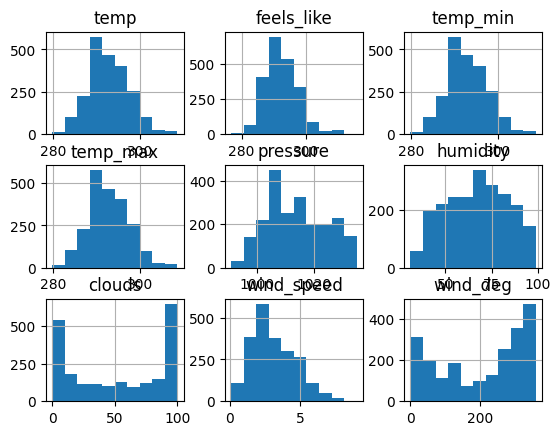

In [4]:
data.hist()

Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, :-1], data.iloc[:, -1]
y = y.map(lambda x: 1 if x=='Rain' else 0)

In [6]:
y.sum()

np.int64(106)

Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123, shuffle=True)

In [8]:
cat_columns = ['weather_now']
numeric_columns = [column for column in X.columns if column != 'weather_now']

In [9]:
from sklearn.compose import ColumnTransformer
# make preprocessing based on feature type
preprocessor = ColumnTransformer(
    [
        ('scaler', StandardScaler(), numeric_columns),
        ('encoder', OneHotEncoder(sparse_output=False), cat_columns)
    ]
)
preprocessor.set_output(transform='pandas')

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['temp', 'feels_like', 'temp_min', 'temp_max',
                                  'pressure', 'humidity', 'clouds',
                                  'wind_speed', 'wind_deg']),
                                ('encoder', OneHotEncoder(sparse_output=False),
                                 ['weather_now'])])

In [10]:
# transform the X
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Train the RandomForest Classifier with GridSearchCV using RepeatedStratifiedKFold

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
params = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', X_train_transformed.shape[1]],
    'n_estimators': [10, 100, 200],
    'class_weight': [{0:1, 1:10}, {0:1, 1:1}],
    'ccp_alpha': [0.001,0.01, 0]
}

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=cv, scoring='roc_auc', verbose=2)
rf_grid.fit(X_train_transformed, y_train)

Fitting 30 folds for each of 108 candidates, totalling 3240 fits
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ccp_alpha=0.001, class_weight={0: 1, 1: 10}, max_depth=5, max_features=s

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.001, 0.01, 0],
                         'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 1}],
                         'max_depth': [5, 10, 15], 'max_features': ['sqrt', 12],
                         'n_estimators': [10, 100, 200]},
             scoring='roc_auc', verbose=2)

Finding the best threshold to make decision to maximize the roc-auc score

In [12]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
best_score, best_treshold = 0, np.nan
for t in np.linspace(0, 1, 100):
    y_pred = rf_grid.predict_proba(X_test_transformed)
    y_pred = y_pred[:, 1] > t
    if roc_auc_score(y_test, y_pred) > best_score:
        best_score = roc_auc_score(y_test, y_pred)
        best_treshold = t

y_pred = rf_grid.predict_proba(X_test_transformed)
y_pred = y_pred[:, 1] > best_treshold
print("Best threshold: ", best_treshold)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best threshold:  0.25252525252525254
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       419
           1       0.19      0.95      0.31        21

    accuracy                           0.80       440
   macro avg       0.59      0.87      0.60       440
weighted avg       0.96      0.80      0.86       440

0.8723718604386862
[[332  87]
 [  1  20]]


Getting the final model by making the pipeline from the preprocessor and the trained model

In [13]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(
    [('preprocess', preprocessor),
     ('predictor', rf_grid.best_estimator_)]
)

In [14]:
y_pred = pipeline.predict_proba(X_test)
y_pred = y_pred[:, 1] > best_treshold

In [15]:
print("Best threshold: ", best_treshold)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best threshold:  0.25252525252525254
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       419
           1       0.19      0.95      0.31        21

    accuracy                           0.80       440
   macro avg       0.59      0.87      0.60       440
weighted avg       0.96      0.80      0.86       440

0.8723718604386862
[[332  87]
 [  1  20]]


Dump the model

In [17]:
import pickle

with open("/home/danil/Desktop/pmldl_assignment1/models/weather_classifier.pkl", 'wb') as f:
    pickle.dump(pipeline, f) 